# Linear Random Forest

In [1]:
from sklearn.linear_model import LinearRegression, Ridge
from lineartree import LinearTreeRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import pandas as pd
from joblib import dump
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import time

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.regression_metrics import regression
from notebooks.utils.lrf import LinearRandomForestRegressor

In [4]:
train =  pd.read_parquet('../../../data/model_input/train_sets/electricity_transformer.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/electricity_transformer.parquet')

In [5]:
y_train = train.OT_next
X_train = train.drop(columns=['date', 'OT_next'])

In [6]:
y_validation = validation.OT_next
X_validation = validation.drop(columns=['date', 'OT_next'])

In [7]:
scaler = StandardScaler().fit(X_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [9]:
n_estimators = [5, 10, 15, 20, 30, 50]

In [10]:
max_depth = [1, 2, 3]
base_mod = [LinearRegression(), Ridge()]

In [11]:
base_est = []
for i in max_depth:
    for mod in base_mod:
        base_est.append(LinearTreeRegressor(base_estimator=mod, max_depth=i))

In [12]:
n_var = [X_train.shape[1]**2, X_train.shape[1]**2/4, X_train.shape[1]**2/9]

We are going to test with different number of features in this case

In [13]:
models_list = []
names_list = []
for m in n_var:
    for n in n_estimators:
        for estim in base_est:
            models_list.append(LinearRandomForestRegressor(n_features=m, est=estim, n_est=n, n_j=-1))
            if isinstance(estim.base_estimator, LinearRegression):
                names_list.append(f'LRF_{n}_{estim.max_depth}_{n_var.index(m)}')
            else:
                names_list.append(f'LRF_{n}_{estim.max_depth}_l2_{n_var.index(m)}')

In [79]:
metrics = regression(models_list, names_list, '../../../data/model_output/metrics/electricity_transformer/lrf.csv', X_train_scaled, y_train, X_validation_scaled, y_validation)
metrics

,Run_Time,Train_RMSE,Validation_RMSE,delta%
LRF_5_1_0,5554.610952,0.477573,0.297833,-37.636028
LRF_5_1_l2_0,1215.074954,0.477773,0.297099,-37.815985
LRF_5_2_l2_0,1630.364790,0.475652,0.299891,-36.951525
LRF_5_1_l2_1,274.564109,0.506308,0.324975,-35.814663
LRF_5_2_l2_1,352.815537,0.543718,0.373272,-31.348207
LRF_5_3_l2_1,310.096895,0.483464,0.355492,-26.469797
LRF_10_1_l2_1,505.521915,0.496863,0.338049,-31.963381
LRF_10_2_l2_1,584.576962,0.500986,0.362169,-27.708823
LRF_15_1_l2_1,709.658618,0.500178,0.352788,-29.467395
LRF_15_2_l2_1,859.345774,0.498986,0.351209,-29.615555


In [80]:
metrics.sort_values(by='Validation_RMSE')

,Run_Time,Train_RMSE,Validation_RMSE,delta%
LRF_5_1_l2_0,1215.074954,0.477773,0.297099,-37.815985
LRF_5_1_0,5554.610952,0.477573,0.297833,-37.636028
LRF_5_2_l2_0,1630.364790,0.475652,0.299891,-36.951525
LRF_5_1_l2_1,274.564109,0.506308,0.324975,-35.814663
LRF_20_2_l2_1,1114.806681,0.490687,0.328419,-33.069462
LRF_10_1_l2_1,505.521915,0.496863,0.338049,-31.963381
LRF_10_2_l2_2,284.733445,0.503104,0.344538,-31.517434
LRF_30_1_l2_1,1401.025815,0.499470,0.350524,-29.820862
LRF_15_2_l2_1,859.345774,0.498986,0.351209,-29.615555
LRF_15_1_l2_1,709.658618,0.500178,0.352788,-29.467395


Let's retrain **LRF_5_1_l2_1** that is the bagging estimator with linear trees of depth 1 using ridge regressions as base estimators and with half of the features.

In [81]:
test =  pd.read_parquet('../../../data/model_input/test_sets/electricity_transformer.parquet')

In [82]:
y_test = test.OT_next
X_test = test.drop(columns=['date', 'OT_next'])

In [83]:
retrain = pd.concat([train, validation])

In [84]:
y_retrain = retrain.OT_next
X_retrain = retrain.drop(columns=['date', 'OT_next'])

In [85]:
scaler_retrain = StandardScaler().fit(X_retrain)

In [86]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [93]:
time1 = time.time()
model = LinearRandomForestRegressor(n_features=X_train.shape[1]**2/4, est=LinearTreeRegressor(base_estimator=Ridge(), max_depth=1), n_est=5, n_j=-1).fit(X_retrain_scaled, y_retrain)
time2 = time.time() - time1

In [94]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 0.3273


In [95]:
train_pred = model.predict(X_retrain_scaled)
rmse_train = root_mean_squared_error(y_retrain, train_pred)

In [96]:
rmse_train

0.4550167093911571

In [97]:
with open('../../../data/model_output/metrics/electricity_transformer/final_metrics.txt', 'a') as f:
     f.write(f'\nLRF; {time2}; {rmse_train}; {rmse}')

In [98]:
dump(model, '../../../data/model_output/models/electricity_transformer/best_lrf.joblib')

['../../../data/model_output/models/electricity_transformer/best_lrf.joblib']

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_17220/2081232494.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],


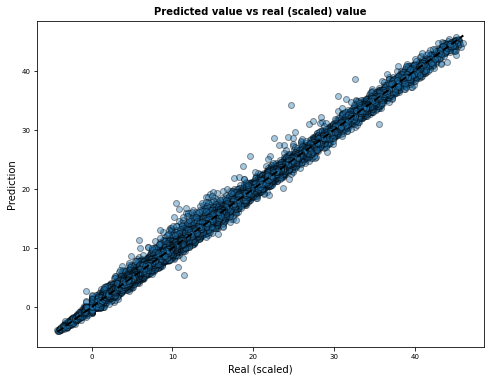

In [99]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain

plt.figure(figsize=(8, 6))

plt.scatter(y_retrain, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],
                'k--', color = 'black', lw=2)
plt.title('Predicted value vs real (scaled) value', fontsize = 10, fontweight = "bold")
plt.xlabel('Real (scaled)')
plt.ylabel('Prediction')
plt.tick_params(labelsize = 7)

In [12]:
from joblib import load
load_mod = load('../../../data/model_output/models/electricity_transformer/best_lrf.joblib')

In [13]:
train_pred = load_mod.predict(X_retrain_scaled)
test_pred = load_mod.predict(X_test_scaled)

In [15]:
mape_train = mean_absolute_percentage_error(y_retrain, train_pred)*100
mape_test = mean_absolute_percentage_error(y_retrain, train_pred)*100

with open('../../../data/model_output/metrics/electricity_transformer/final_MAPE.txt', 'a') as f:
    f.write(f'\nLRF;{mape_train};{mape_test}')

In [16]:
mape_train, mape_test

(1504643065369545.2, 1504643065369545.2)

In [14]:
mae_train = mean_absolute_error(y_retrain, train_pred)
mae_test = mean_absolute_error(y_test, test_pred)

In [15]:
mae_train, mae_test

(0.5119592860717469, 0.3697713655009326)